In [1]:
from gurobipy import *

In [33]:
def IPS6(ship_num,stack_num,height,time,init,size,beta):
    # nと初期配置を変更しなければいけない
    O1=[i+1 for i in range(ship_num)]

    S=[i+1 for i in range(stack_num)]
    H=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    T=[i+1 for i in range(time)]

    
    from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
    import random
    from random import seed
    import numpy as np
    from scipy.stats import multivariate_normal

    # 期待値と分散共分散行列の準備
    a=np.arange(2*ship_num)
    a=list(a)
    a=random.sample(a,ship_num)
    mean=np.sort(a)
    cov=np.zeros((ship_num,ship_num))
    for i in range(ship_num):
        for j in range(ship_num):
            if i==j:
                cov[i][i]=2*abs(np.random.randn())
    for i in range(ship_num):
        for j in range(ship_num):
            if i!=j:
                cov[i][j]=(-0.75)**abs(i-j)

    # numpy を用いた生成
    data_1 = np.random.multivariate_normal(mean, cov, size=size)

    # print(data_1.shape)

    # print(np.mean(data_1, axis=0))

    # print(np.cov(data_1, rowvar=False))

    # print(data_1)
    O_=np.argsort(data_1)
    O_=O_+np.ones((size,ship_num)).astype(int)
    O=O_.tolist()

    # data_2 = multivariate_normal(mean, cov).rvs(size=200)

    # print(data_2.shape)

    # print(np.mean(data_2, axis=0))

    # print(np.cov(data_2, rowvar=False))

    a=[]
    b={}
    for i in O:
      # print(i)
      if not i in a:
        a.append(i)
    for j in a:
      b[tuple(j)]=O.count(j)

    m=Model("IPS6")

    alpha=m.addVar(vtype="C")

    # 変数の定義
    x,z,w,c,d={},{},{},{},{}
    for s in S:
      for h in H:
        for p in P:
          for t in T:
            x[s,h,p,t]=m.addVar(vtype="B")


    for s in S:
      for h in H:
        for p in P:
          for t in T:
            w[s,h,p,t]=m.addVar(vtype="C",lb=0)
            z[s,h,p,t]=m.addVar(vtype="C",lb=0)


    for s in S:
      for h in range(2,len(H)+1):
        for i,o in enumerate(O):
          c[s,h,i]=m.addVar(vtype="c",lb=0)

    for i in range(len(O)):
      d[i]=m.addVar(vtype="C",lb=0)

    # 制約条件
    for p in P:
      for t in range(1,len(T)):
          m.addConstr(quicksum(w[s,h,p,t] for s in S for h in H)==quicksum(z[s,h,p,t] for s in S for h in H))

    for t in range(1,len(T)):
      m.addConstr(quicksum(w[s,h,p,t] for s in S for h in H for p in P)<=1)
      m.addConstr(quicksum(z[s,h,p,t] for s in S for h in H for p in P)<=1)

    for t in range(1,len(T)-1):
      m.addConstr(quicksum(w[s,h,p,t+1] for s in S for h in H for p in P)<=quicksum(w[s,h,p,t] for s in S for h in H for p in P))

    for s in S:
      for t in range(2,len(T)+1):
        m.addConstr(quicksum(x[s,1,p,t] for p in P)+quicksum(z[s,1,p,t] for p in P)<=1)

    for s in S:
      for h in range(1,len(H)):
        for t in range(1,len(T)+1):
          m.addConstr(quicksum(x[s,h+1,p,t] for p in P)+quicksum(w[s,h,p,t] for p in P)+quicksum(z[s,h+1,p,t] for p in P)<=quicksum(x[s,h,p,t] for p in P))

    for s in S:
      for h in H:
        for p in P:
          for t in range(1,len(T)):
            m.addConstr(x[s,h,p,t]+z[s,h,p,t]==x[s,h,p,t+1]+w[s,h,p,t])

    for s in S:
      for h in range(1,len(H)):
        for t in range(1,len(T)):
          m.addConstr(quicksum(x[s,h,p,t] for p in P)+quicksum(x[s,h+1,p,t] for p in P)+quicksum(w[s,h,p,t] for p in P)+quicksum(z[s,h+1,p,t] for p in P)+quicksum(z[s,h,p,t] for p in P)<=2)

    for s in S:
      for t in range(1,len(T)-1):
        m.addConstr(quicksum(z[s,h,p,t] for h in H for p in P)+quicksum(w[s,h,p,t+1] for h in H for p in P)<=1)

    for s in S:
      for p in P:
        for t in range(1,len(T)-1):
          m.addConstr(quicksum(w[s,h,p,t] for h in H)+quicksum(z[s,h,p,t+1] for h in H)<=1)
          
    for s in S:
      for h in H:
        m.addConstr(w[s,h,1,len(T)-1]==0)

    for s in S:
      for p in range(2,len(P)+1):
        m.addConstr(w[s,1,p,len(T)-1]==0)

    for s in S:
      for h in H:
        for p in P:
          m.addConstr(z[s,h,p,len(T)]==0)
          m.addConstr(w[s,h,p,len(T)]==0)

    for s in S:
      for h in range(2,len(H)+1):
        for h_ in range(1,h):
          for i,o in enumerate(O):
            for j,p in enumerate(o):
              m.addConstr(c[s,h,i]>=quicksum(x[s,h,k,len(T)] for k in o[j:])-quicksum(x[s,h_,k,len(T)] for k in o[j:]))

    for i in range(len(O)):
      m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)

      # 初期配置の制約
    for i in init:
      m.addConstr(x[i[0],i[1],i[2],1]==1)
    
    beta=0.8
    # m.setObjective(alpha+10**(-5)*quicksum(y[s,k,t] for s in S for k in S if s!=k for t in range(1,len(T)))+quicksum(w[i] for i in range(len(O)))/((1-beta)*len(O)))
    m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O))+10**(-5)*quicksum(z[s,h,p,t] for s in S for h in H for p in P for t in range(1,len(T))))

    m.optimize()

    print("================================================")

    if m.Status == GRB.OPTIMAL:
      EPS=1.e-6
    # for (s,h,p,t) in x:
    #   if t==len(T):
    #     if x[s,h,p,t].X>EPS:
    #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

      for (s,h,i) in c:
        if c[s,h,i].X>EPS:
          print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

      global result
      result=np.zeros((height,stack_num))
      for (s,h,p,t) in x:
        if x[s,h,p,len(T)].X>EPS:
      # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
          result[height-h][s-1]=int(p)

      result=result.astype(int)
      print("VaR=",alpha.X)
      print("the objective function", m.objVal)
      print(result)

      data_2 = np.random.multivariate_normal(mean, cov, size=size)

      OR_=np.argsort(data_2)
      OR_=OR_+np.ones((size,ship_num)).astype(int)
      OR=OR_.tolist()

      global penalty
      penalty=[]
      for k in OR:
        O=k
        a=0
        for j in range(stack_num):
            for i in range(1,height):
                for i_ in range(i+1,height+1):
                    if not result[i-1][j]==0 or result[i_-1][j]==0:
                        if O[result[i-1][j]-1]>O[result[i_-1][j]-1]:
                            a+=1
                            # print("penalty!")
                                # print(i,i_,j+1,O)
                            break
        penalty.append(a)
        # print(a)
      penalty=np.sort(penalty)
      penalty=penalty[round(0.2*size):]
      print(penalty)

      import matplotlib.pyplot as plt
      plt.boxplot(penalty)


In [42]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
ship_num=5
np.random.seed(0)
size=100
# 期待値と分散共分散行列の準備
a=np.arange(2*ship_num)
a=list(a)
a=random.sample(a,ship_num)
mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=2*abs(np.random.randn())
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=(-0.75)**abs(i-j)

# numpy を用いた生成
data_1 = np.random.multivariate_normal(mean, cov, size=size)

# print(data_1.shape)

# print(np.mean(data_1, axis=0))

# print(np.cov(data_1, rowvar=False))

# print(data_1)
O_=np.argsort(data_1)
O_=O_+np.ones((size,ship_num)).astype(int)
O=O_.tolist()
a=[]
b={}
for i in O:
    # print(i)
    if not i in a:
        a.append(i)
for j in a:
    b[tuple(j)]=O.count(j)
b

{(1, 2, 4, 3, 5): 13,
 (1, 2, 3, 4, 5): 26,
 (4, 2, 1, 3, 5): 3,
 (2, 1, 4, 3, 5): 12,
 (1, 3, 2, 4, 5): 7,
 (2, 3, 1, 4, 5): 2,
 (2, 1, 3, 4, 5): 11,
 (4, 1, 2, 3, 5): 1,
 (1, 3, 2, 5, 4): 3,
 (1, 2, 3, 5, 4): 4,
 (2, 1, 3, 5, 4): 2,
 (1, 4, 2, 3, 5): 3,
 (3, 2, 1, 5, 4): 1,
 (3, 2, 1, 4, 5): 1,
 (2, 4, 1, 3, 5): 3,
 (1, 2, 4, 5, 3): 1,
 (2, 5, 3, 1, 4): 1,
 (1, 3, 4, 2, 5): 1,
 (2, 4, 3, 1, 5): 2,
 (2, 3, 1, 5, 4): 2,
 (3, 1, 2, 5, 4): 1}

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-03
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26229 rows, 3976 columns and 187958 nonzeros
Model fingerprint: 0x735deed8
Variable types: 3351 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 23038 rows and 2625 columns
Presolve time: 0.42s
Presolved: 3191 rows, 1351 columns, 30364 nonzeros
Variable types: 908 continuous, 443 integer (443 binary)
Found heuristic solution: objective 4.2000400

Root relaxation: objective 4.408393e-01, 1509 iterations, 0.08 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


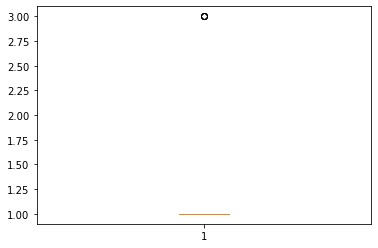

In [34]:
ship_num=5
stack_num=5
height=5
init=[[1,1,5],[1,2,3],[1,3,1],[2,1,5],[2,2,4],[3,1,4],[3,2,4],[3,3,1],[4,1,5],[4,2,2],[4,3,3],[5,1,2],[5,2,1]]
IPS6(ship_num,stack_num,height,5,init,100,0.8)

In [36]:
def robust(ship_num,stack_num,height,time,init,size,Gamma):
    # nと初期配置を変更しなければいけない
    U=[i+1 for i in range(ship_num)]

    S=[i+1 for i in range(stack_num)]
    H=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    T=[i+1 for i in range(time)]

    import numpy as np
    import itertools
    O=[]
    for i in itertools.permutations(U):
      a=0
      for j in range(len(U)):
        for k in range(j+1,len(U)):
          if i[j]>i[k]:
            a+=1
      if a<=Gamma:
        O.append(list(i))

    m=Model("IPS6")


    # 変数の定義
    x,z,w,c,d={},{},{},{},{}
    for s in S:
      for h in H:
        for p in P:
          for t in T:
            x[s,h,p,t]=m.addVar(vtype="B")


    for s in S:
      for h in H:
        for p in P:
          for t in T:
            w[s,h,p,t]=m.addVar(vtype="C",lb=0)
            z[s,h,p,t]=m.addVar(vtype="C",lb=0)


    for s in S:
      for h in range(2,len(H)+1):
        for i,o in enumerate(O):
          c[s,h,i]=m.addVar(vtype="c",lb=0)

    for i in range(len(O)):
      d[i]=m.addVar(vtype="C",lb=0)

    # 制約条件
    for p in P:
      for t in range(1,len(T)):
          m.addConstr(quicksum(w[s,h,p,t] for s in S for h in H)==quicksum(z[s,h,p,t] for s in S for h in H))

    for t in range(1,len(T)):
      m.addConstr(quicksum(w[s,h,p,t] for s in S for h in H for p in P)<=1)
      m.addConstr(quicksum(z[s,h,p,t] for s in S for h in H for p in P)<=1)

    for t in range(1,len(T)-1):
      m.addConstr(quicksum(w[s,h,p,t+1] for s in S for h in H for p in P)<=quicksum(w[s,h,p,t] for s in S for h in H for p in P))

    for s in S:
      for t in range(2,len(T)+1):
        m.addConstr(quicksum(x[s,1,p,t] for p in P)+quicksum(z[s,1,p,t] for p in P)<=1)

    for s in S:
      for h in range(1,len(H)):
        for t in range(1,len(T)+1):
          m.addConstr(quicksum(x[s,h+1,p,t] for p in P)+quicksum(w[s,h,p,t] for p in P)+quicksum(z[s,h+1,p,t] for p in P)<=quicksum(x[s,h,p,t] for p in P))

    for s in S:
      for h in H:
        for p in P:
          for t in range(1,len(T)):
            m.addConstr(x[s,h,p,t]+z[s,h,p,t]==x[s,h,p,t+1]+w[s,h,p,t])

    for s in S:
      for h in range(1,len(H)):
        for t in range(1,len(T)):
          m.addConstr(quicksum(x[s,h,p,t] for p in P)+quicksum(x[s,h+1,p,t] for p in P)+quicksum(w[s,h,p,t] for p in P)+quicksum(z[s,h+1,p,t] for p in P)+quicksum(z[s,h,p,t] for p in P)<=2)

    for s in S:
      for t in range(1,len(T)-1):
        m.addConstr(quicksum(z[s,h,p,t] for h in H for p in P)+quicksum(w[s,h,p,t+1] for h in H for p in P)<=1)

    for s in S:
      for p in P:
        for t in range(1,len(T)-1):
          m.addConstr(quicksum(w[s,h,p,t] for h in H)+quicksum(z[s,h,p,t+1] for h in H)<=1)
          
    for s in S:
      for h in H:
        m.addConstr(w[s,h,1,len(T)-1]==0)

    for s in S:
      for p in range(2,len(P)+1):
        m.addConstr(w[s,1,p,len(T)-1]==0)

    for s in S:
      for h in H:
        for p in P:
          m.addConstr(z[s,h,p,len(T)]==0)
          m.addConstr(w[s,h,p,len(T)]==0)

    for s in S:
      for h in range(2,len(H)+1):
        for h_ in range(1,h):
          for i,o in enumerate(O):
            for j,p in enumerate(o):
              m.addConstr(c[s,h,i]>=quicksum(x[s,h,k,len(T)] for k in o[j:])-quicksum(x[s,h_,k,len(T)] for k in o[j:]))


      # 初期配置の制約
    for i in init:
      m.addConstr(x[i[0],i[1],i[2],1]==1)
    
    # m.setObjective(alpha+10**(-5)*quicksum(y[s,k,t] for s in S for k in S if s!=k for t in range(1,len(T)))+quicksum(w[i] for i in range(len(O)))/((1-beta)*len(O)))
    m.setObjective(quicksum(c[s,h,i] for s in S for h in H if h!=1 for i in range(len(O)))+10**(-5)*quicksum(z[s,h,p,t] for s in S for h in H for p in P for t in range(1,len(T))))

    m.optimize()

    print("================================================")

    if m.Status == GRB.OPTIMAL:
      EPS=1.e-6
    # for (s,h,p,t) in x:
    #   if t==len(T):
    #     if x[s,h,p,t].X>EPS:
    #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

      for (s,h,i) in c:
        if c[s,h,i].X>EPS:
          print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

      global result_r
      result_r=np.zeros((height,stack_num))
      for (s,h,p,t) in x:
        if x[s,h,p,len(T)].X>EPS:
      # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
          result_r[height-h][s-1]=int(p)

      result_r=result_r.astype(int)
      print("the objective function", m.objVal)
      print(result_r)

      from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
      import random
      from random import seed
      import numpy as np
      from scipy.stats import multivariate_normal
      ship_num=5
      np.random.seed(0)

      # 期待値と分散共分散行列の準備
      a=np.arange(2*ship_num)
      a=list(a)
      a=random.sample(a,ship_num)
      mean=np.sort(a)
      cov=np.zeros((ship_num,ship_num))
      for i in range(ship_num):
          for j in range(ship_num):
              if i==j:
                  cov[i][i]=2*abs(np.random.randn())
      for i in range(ship_num):
          for j in range(ship_num):
              if i!=j:
                  cov[i][j]=(-0.75)**abs(i-j)
      data_2 = np.random.multivariate_normal(mean, cov, size=size)

      OR_=np.argsort(data_2)
      OR_=OR_+np.ones((size,ship_num)).astype(int)
      OR=OR_.tolist()

      global penalty_r
      penalty_r=[]
      for k in OR:
        O=k
        a=0
        for j in range(stack_num):
            for i in range(1,height):
                for i_ in range(i+1,height+1):
                    if not result_r[i-1][j]==0 or result_r[i_-1][j]==0:
                        if O[result_r[i-1][j]-1]>O[result_r[i_-1][j]-1]:
                            a+=1
                            # print("penalty!")
                                # print(i,i_,j+1,O)
                            break
        penalty_r.append(a)
        # print(a)
      penalty_r=np.sort(penalty_r)
      penalty_r=penalty_r[round(0.2*size):]
      print(penalty_r)

      import matplotlib.pyplot as plt
      plt.boxplot(penalty_r)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 8379 rows, 2484 columns and 61508 nonzeros
Model fingerprint: 0xd7b1334c
Variable types: 1859 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 112.0000300
Presolve removed 704 rows and 890 columns
Presolve time: 0.18s
Presolved: 7675 rows, 1594 columns, 72293 nonzeros
Variable types: 571 continuous, 1023 integer (443 binary)

Root relaxation: objective 1.837383e+01, 2222 iterations, 0.13 seconds (0.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.37383    0   90  112.00003   18.37383  83.6%     -    0s
H    0     0     

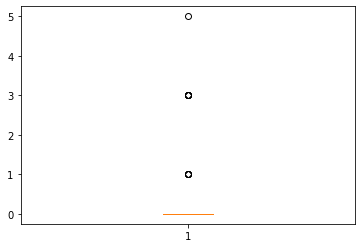

In [37]:
ship_num=5
stack_num=5
height=5
init=[[1,1,5],[1,2,3],[1,3,1],[2,1,5],[2,2,4],[3,1,4],[3,2,4],[3,3,1],[4,1,5],[4,2,2],[4,3,3],[5,1,2],[5,2,1]]
robust(ship_num,stack_num,height,5,init,100,3)
# AI.solve()